**Курсовой проект для курса "Python для Data Science"**

Материалы к проекту (файлы):
- train.csv
- test.csv

**Задание: Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели предсказать цены для квартир из файла test.csv.**

**Целевая переменная**: Price

Метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

**Сдача проекта**:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price). В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

**Сроки и условия сдачи**:
- Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту").
- Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
- При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
- Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
- Успешный проект нельзя пересдать в целях повышения результата.
- Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
- В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

*Примечание*: Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

**Рекомендации для файла с кодом (ipynb)**:
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. Допускается применение библиотек Python и моделей машинного обучения,
которые были в курсе Python для Data Science. Градиентный бустинг изучается
в последующих курсах, поэтому в этом проекте его применять не следует.
Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse, accuracy_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use(['dark_background']) # тёмный фон графиков

In [2]:
train_dataset = '../../data/house_price/train.csv'
test_dataset = '../../data/house_price/test.csv'
prepared_train_dataset = '../../data/house_price/train_prepared.csv'
df_orig = pd.read_csv(train_dataset)
df_test_orig = pd.read_csv(test_dataset)
print(df_orig.shape)
df_orig.head()

(10000, 20)


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [3]:
df_orig.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [4]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

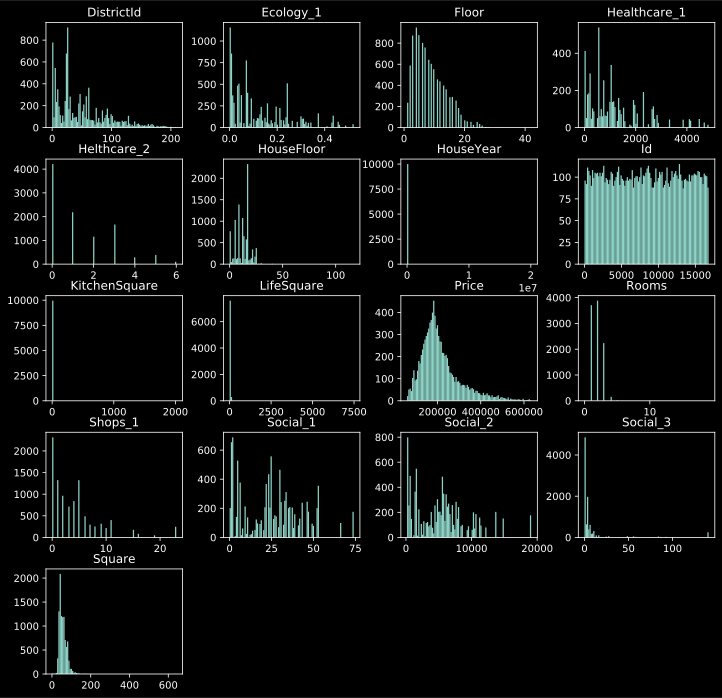

In [5]:
df_orig.hist(figsize=(12,12), bins=100, grid=False);

# Обработка данных

## Удаление столбцов с пропущенными данными + коррекция года постройки

In [6]:
df = df_orig
df_test = df_test_orig

# Замена некорректных значений года пострйки 4968 и 20052010 в строчке № 4189 и 1497 столбца HouseYear
df['HouseYear'].describe().round()
df['HouseYear'].sort_values(ascending=False).head()
# замена значения в строчке № 4189 столбца HouseYear на значение
df.loc[4189, 'HouseYear'] = 1968
df.loc[1497, 'HouseYear'] = 2005
df.loc[1497, 'HouseYear']

df = pd.get_dummies(df)
df_test = pd.get_dummies(df_test)

df = df.drop(['LifeSquare', 'Healthcare_1'], axis=1)
df_test = df_test.drop(['LifeSquare', 'Healthcare_1'], axis=1)

y = df['Price']
x = df.drop('Price', axis=1)

## Замена пропущенных значений на медианные + корреция года постройки

In [7]:
df = df_orig
df_test = df_test_orig

# Замена некорректных значений года пострйки 4968 и 20052010 в строчке № 4189 и 1497 столбца HouseYear
df['HouseYear'].describe().round()
df['HouseYear'].sort_values(ascending=False).head()
# замена значения в строчке № 4189 столбца HouseYear на значение
df.loc[4189, 'HouseYear'] = 1968
df.loc[1497, 'HouseYear'] = 2005
df.loc[1497, 'HouseYear']

df = pd.get_dummies(df)
df_test = pd.get_dummies(df_test)

df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['LifeSquare'].median()
df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()
df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] = df_test['LifeSquare'].median()
df_test.loc[df_test['Healthcare_1'].isnull(), 'Healthcare_1'] = df_test['Healthcare_1'].median()

y = df['Price']
x = df.drop('Price', axis=1)

## Замена пропущенных значений на медианные + корреция года постройки - удаление домов 1977 года

In [8]:
df = df_orig
df_test = df_test_orig

# Замена некорректных значений года пострйки 4968 и 20052010 в строчке № 4189 и 1497 столбца HouseYear
df['HouseYear'].describe().round()
df['HouseYear'].sort_values(ascending=False).head()
# замена значения в строчке № 4189 столбца HouseYear на значение
df.loc[4189, 'HouseYear'] = 1968
df.loc[1497, 'HouseYear'] = 2005
df.loc[1497, 'HouseYear']

df = pd.get_dummies(df)
df_test = pd.get_dummies(df_test)

df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['LifeSquare'].median()
df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()
df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] = df_test['LifeSquare'].median()
df_test.loc[df_test['Healthcare_1'].isnull(), 'Healthcare_1'] = df_test['Healthcare_1'].median()

# удаление строк с 1977 годом
df = df[df.HouseYear != 1977]

y = df['Price']
x = df.drop('Price', axis=1)

## Замена пропущенных значений Healthcare_1 на медианные + корреция года постройки. Пустые LifeSquare = Square /1.62

In [9]:
df = df_orig
df_test = df_test_orig

# Замена некорректных значений года пострйки 4968 и 20052010 в строчке № 4189 и 1497 столбца HouseYear
df['HouseYear'].describe().round()
df['HouseYear'].sort_values(ascending=False).head()
# замена значения в строчке № 4189 столбца HouseYear на значение
df.loc[4189, 'HouseYear'] = 1968
df.loc[1497, 'HouseYear'] = 2005
df.loc[1497, 'HouseYear']

df = pd.get_dummies(df)
df_test = pd.get_dummies(df_test)

#df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['LifeSquare'].median()
df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()
#df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] = df_test['LifeSquare'].median()
df_test.loc[df_test['Healthcare_1'].isnull(), 'Healthcare_1'] = df_test['Healthcare_1'].median()

# вычисление коэффициента отношения площадей
df['sq_mult'] = df['Square'] / df['LifeSquare']
#df_test['sq_mult'] = df_test['Square'] / df_test['LifeSquare']

df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['Square'] / 1.62  # mean & 50% sq_mult
df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] = df_test['Square'] / 1.62

y = df['Price']
x = df.drop('Price', axis=1)

df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,sq_mult
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,7887.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.211282,6.273300,8.526700,12.609400,1984.865700,0.118858,...,1.319500,4.231300,214138.857399,0.009700,0.990300,0.027500,0.972500,0.082500,0.917500,2.125507
std,4859.01902,43.587592,0.839512,21.058732,76.862511,28.560917,5.241148,6.775974,18.411517,0.119025,...,1.493601,4.806341,92872.293865,0.098015,0.098015,0.163543,0.163543,0.275139,0.275139,4.474246
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1910.000000,0.000000,...,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010921
25%,4169.50000,20.000000,1.000000,41.774881,24.229552,1.000000,4.000000,9.000000,1974.000000,0.017647,...,0.000000,1.000000,153872.633942,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.434892
50%,8394.50000,36.000000,2.000000,52.513310,33.266172,6.000000,7.000000,13.000000,1977.000000,0.075424,...,1.000000,3.000000,192269.644879,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.619362
75%,12592.50000,75.000000,2.000000,65.900625,44.872669,9.000000,12.000000,17.000000,2001.000000,0.195781,...,2.000000,6.000000,249135.462171,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.797800
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2020.000000,0.521867,...,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,166.648780


## Замена пропущенных значений Healthcare_1 на медианные + корреция года постройки. Пустые LifeSquare = Square /1.62. Если жилая площадь больше общей площади, то общая площадь = жилой

In [10]:
df = df_orig
df_test = df_test_orig

# Замена некорректных значений года пострйки 4968 и 20052010 в строчке № 4189 и 1497 столбца HouseYear
df['HouseYear'].describe().round()
df['HouseYear'].sort_values(ascending=False).head()
# замена значения в строчке № 4189 столбца HouseYear на значение
df.loc[4189, 'HouseYear'] = 1968
df.loc[1497, 'HouseYear'] = 2005
df.loc[1497, 'HouseYear']

df = pd.get_dummies(df)
df_test = pd.get_dummies(df_test)

#df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['LifeSquare'].median()
df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()
#df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] = df_test['LifeSquare'].median()
df_test.loc[df_test['Healthcare_1'].isnull(), 'Healthcare_1'] = df_test['Healthcare_1'].median()

# вычисление коэффициента отношения площадей
#df['sq_mult'] = df['Square'] / df['LifeSquare']
#df_test['sq_mult'] = df_test['Square'] / df_test['LifeSquare']

df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['Square'] / 1.62  # mean & 50% sq_mult
df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] = df_test['Square'] / 1.62

# Если жилая площадь больше общей площади, то обзая площадь = жилой
df['Square'] = np.where((df['LifeSquare'] > df['Square']), df['LifeSquare'], df['Square'])
df_test['Square'] = np.where((df_test['LifeSquare'] > df_test['Square']), df_test['LifeSquare'], df_test['Square'])

y = df['Price']
x = df.drop('Price', axis=1)

df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,57.223484,37.211282,6.273300,8.526700,12.609400,1984.865700,0.118858,...,1026.358900,1.319500,4.231300,214138.857399,0.009700,0.990300,0.027500,0.972500,0.082500,0.917500
std,4859.01902,43.587592,0.839512,77.309420,76.862511,28.560917,5.241148,6.775974,18.411517,0.119025,...,746.662828,1.493601,4.806341,92872.293865,0.098015,0.098015,0.163543,0.163543,0.275139,0.275139
min,0.00000,0.000000,0.000000,2.377248,0.370619,0.000000,1.000000,0.000000,1910.000000,0.000000,...,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4169.50000,20.000000,1.000000,41.866858,24.229552,1.000000,4.000000,9.000000,1974.000000,0.017647,...,830.000000,0.000000,1.000000,153872.633942,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,8394.50000,36.000000,2.000000,52.633651,33.266172,6.000000,7.000000,13.000000,1977.000000,0.075424,...,900.000000,1.000000,3.000000,192269.644879,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,12592.50000,75.000000,2.000000,66.004634,44.872669,9.000000,12.000000,17.000000,2001.000000,0.195781,...,990.000000,2.000000,6.000000,249135.462171,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,16798.00000,209.000000,19.000000,7480.592129,7480.592129,2014.000000,42.000000,117.000000,2020.000000,0.521867,...,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Kaggle score 0.72584
Замена пропущенных значений Healthcare_1 на медианные

корреция года постройки

Пустые LifeSquare = Square /1.62. 

Если жилая площадь больше общей площади, то общая площадь = жилой. 

замена LifeSquare < 10 на Square / 1.62

если Room = 0, то Room = 1

In [11]:
df = df_orig
df_test = df_test_orig

# Замена некорректных значений года пострйки 4968 и 20052010 в строчке № 4189 и 1497 столбца HouseYear
df['HouseYear'].describe().round()
df['HouseYear'].sort_values(ascending=False).head()
# замена значения в строчке № 4189 столбца HouseYear на значение
df.loc[4189, 'HouseYear'] = 1968
df.loc[1497, 'HouseYear'] = 2005
df.loc[1497, 'HouseYear']

df = pd.get_dummies(df)
df_test = pd.get_dummies(df_test)

#df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['LifeSquare'].median()
df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()
#df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] = df_test['LifeSquare'].median()
df_test.loc[df_test['Healthcare_1'].isnull(), 'Healthcare_1'] = df_test['Healthcare_1'].median()

# вычисление коэффициента отношения площадей
#df['sq_mult'] = df['Square'] / df['LifeSquare']
#df_test['sq_mult'] = df_test['Square'] / df_test['LifeSquare']

df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['Square'] / 1.62  # mean & 50% sq_mult
df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] = df_test['Square'] / 1.62

# Если жилая площадь больше общей площади, то обзая площадь = жилой
df['Square'] = np.where((df['LifeSquare'] > df['Square']), df['LifeSquare'], df['Square'])
df_test['Square'] = np.where((df_test['LifeSquare'] > df_test['Square']), df_test['LifeSquare'], df_test['Square'])

# замена LifeSquare < 10 на Square / 1.62
df['LifeSquare'] = np.where((df['LifeSquare'] < 10), df['Square'] / 1.62, df['LifeSquare'])
df_test['LifeSquare'] = np.where((df_test['LifeSquare'] < 10), df_test['Square'] / 1.62, df_test['LifeSquare'])

# если Room = 0, то Room = 1
df['Rooms'] = np.where((df['Rooms'] == 0), 1, df['Rooms'])

y = df['Price']
x = df.drop('Price', axis=1)

df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.891300,57.223484,37.868223,6.273300,8.526700,12.609400,1984.865700,0.118858,...,1026.358900,1.319500,4.231300,214138.857399,0.009700,0.990300,0.027500,0.972500,0.082500,0.917500
std,4859.01902,43.587592,0.838185,77.309420,76.731834,28.560917,5.241148,6.775974,18.411517,0.119025,...,746.662828,1.493601,4.806341,92872.293865,0.098015,0.098015,0.163543,0.163543,0.275139,0.275139
min,0.00000,0.000000,1.000000,2.377248,1.467437,0.000000,1.000000,0.000000,1910.000000,0.000000,...,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4169.50000,20.000000,1.000000,41.866858,24.875682,1.000000,4.000000,9.000000,1974.000000,0.017647,...,830.000000,0.000000,1.000000,153872.633942,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,8394.50000,36.000000,2.000000,52.633651,33.588079,6.000000,7.000000,13.000000,1977.000000,0.075424,...,900.000000,1.000000,3.000000,192269.644879,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,12592.50000,75.000000,2.000000,66.004634,45.083297,9.000000,12.000000,17.000000,2001.000000,0.195781,...,990.000000,2.000000,6.000000,249135.462171,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,16798.00000,209.000000,19.000000,7480.592129,7480.592129,2014.000000,42.000000,117.000000,2020.000000,0.521867,...,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Kaggle score 0.72596
Замена пропущенных значений Healthcare_1 на медианные

корреция года постройки

Пустые LifeSquare = Square /1.62. 

Если жилая площадь больше общей площади, то жилая площадь = общей площади 

замена LifeSquare < 10 на Square / 1.62

если Room = 0, то Room = 1

удалить Id

In [12]:
df = df_orig
df_test = df_test_orig

# Замена некорректных значений года пострйки 4968 и 20052010 в строчке № 4189 и 1497 столбца HouseYear
df['HouseYear'].describe().round()
df['HouseYear'].sort_values(ascending=False).head()
# замена значения в строчке № 4189 столбца HouseYear на значение
df.loc[4189, 'HouseYear'] = 1968
df.loc[1497, 'HouseYear'] = 2005
df.loc[1497, 'HouseYear']

df = pd.get_dummies(df)
df_test = pd.get_dummies(df_test)

#df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['LifeSquare'].median()
df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()
#df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] = df_test['LifeSquare'].median()
df_test.loc[df_test['Healthcare_1'].isnull(), 'Healthcare_1'] = df_test['Healthcare_1'].median()

# вычисление коэффициента отношения площадей
#df['sq_mult'] = df['Square'] / df['LifeSquare']
#df_test['sq_mult'] = df_test['Square'] / df_test['LifeSquare']

df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['Square'] / 1.62  # mean & 50% sq_mult
df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] = df_test['Square'] / 1.62

# Если жилая площадь больше общей площади, то обзая площадь = жилой
df['LifeSquare'] = np.where((df['LifeSquare'] > df['Square']), df['Square'], df['LifeSquare'])
df_test['LifeSquare'] = np.where((df_test['LifeSquare'] > df_test['Square']), df_test['Square'], df_test['LifeSquare'])

# замена LifeSquare < 10 на Square / 1.62
df['LifeSquare'] = np.where((df['LifeSquare'] < 10), df['Square'] / 1.62, df['LifeSquare'])
df_test['LifeSquare'] = np.where((df_test['LifeSquare'] < 10), df_test['Square'] / 1.62, df_test['LifeSquare'])

# если Room = 0, то Room = 1
df['Rooms'] = np.where((df['Rooms'] == 0), 1, df['Rooms'])

df = df.drop('Id', axis=1)
df_test = df_test.drop('Id', axis=1)

y = df['Price']
x = df.drop('Price', axis=1)

df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.891300,56.315775,36.960338,6.273300,8.526700,12.609400,1984.865700,0.118858,24.687000,...,1026.358900,1.319500,4.231300,214138.857399,0.009700,0.990300,0.027500,0.972500,0.082500,0.917500
std,43.587592,0.838185,21.058732,17.870918,28.560917,5.241148,6.775974,18.411517,0.119025,17.532614,...,746.662828,1.493601,4.806341,92872.293865,0.098015,0.098015,0.163543,0.163543,0.275139,0.275139
min,0.000000,1.000000,1.136859,0.701765,0.000000,1.000000,0.000000,1910.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,1.000000,41.774881,24.865763,1.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,...,830.000000,0.000000,1.000000,153872.633942,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,36.000000,2.000000,52.513310,33.575121,6.000000,7.000000,13.000000,1977.000000,0.075424,25.000000,...,900.000000,1.000000,3.000000,192269.644879,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,75.000000,2.000000,65.900625,44.982354,9.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,...,990.000000,2.000000,6.000000,249135.462171,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,209.000000,19.000000,641.065193,638.163193,2014.000000,42.000000,117.000000,2020.000000,0.521867,74.000000,...,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
df = df_orig
df_test = df_test_orig

# Замена некорректных значений года пострйки 4968 и 20052010 в строчке № 4189 и 1497 столбца HouseYear
df['HouseYear'].describe().round()
df['HouseYear'].sort_values(ascending=False).head()
# замена значения в строчке № 4189 столбца HouseYear на значение
df.loc[4189, 'HouseYear'] = 1968
df.loc[1497, 'HouseYear'] = 2005
df.loc[1497, 'HouseYear']

df = pd.get_dummies(df)
df_test = pd.get_dummies(df_test)

#df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['LifeSquare'].median()
df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()
#df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] = df_test['LifeSquare'].median()
df_test.loc[df_test['Healthcare_1'].isnull(), 'Healthcare_1'] = df_test['Healthcare_1'].median()

# вычисление коэффициента отношения площадей
#df['sq_mult'] = df['Square'] / df['LifeSquare']
#df_test['sq_mult'] = df_test['Square'] / df_test['LifeSquare']

df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['Square']  # mean & 50% sq_mult
df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] = df_test['Square']

# Если жилая площадь больше общей площади, то обзая площадь = жилой
df['LifeSquare'] = np.where((df['LifeSquare'] > df['Square']), df['Square'], df['LifeSquare'])
df_test['LifeSquare'] = np.where((df_test['LifeSquare'] > df_test['Square']), df_test['Square'], df_test['LifeSquare'])

# замена LifeSquare < 10 на Square / 1.62
df['LifeSquare'] = np.where((df['LifeSquare'] < 10), df['Square'], df['LifeSquare'])
df_test['LifeSquare'] = np.where((df_test['LifeSquare'] < 10), df_test['Square'], df_test['LifeSquare'])

# если Room = 0, то Room = 1
df['Rooms'] = np.where((df['Rooms'] == 0), 1, df['Rooms'])

df = df.drop('Id', axis=1)
df_test = df_test.drop('Id', axis=1)

y = df['Price']
x = df.drop('Price', axis=1)

df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.891300,56.315775,42.292724,6.273300,8.526700,12.609400,1984.865700,0.118858,24.687000,...,1026.358900,1.319500,4.231300,214138.857399,0.009700,0.990300,0.027500,0.972500,0.082500,0.917500
std,43.587592,0.838185,21.058732,22.122392,28.560917,5.241148,6.775974,18.411517,0.119025,17.532614,...,746.662828,1.493601,4.806341,92872.293865,0.098015,0.098015,0.163543,0.163543,0.275139,0.275139
min,0.000000,1.000000,1.136859,1.136859,0.000000,1.000000,0.000000,1910.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,1.000000,41.774881,27.565049,1.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,...,830.000000,0.000000,1.000000,153872.633942,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,36.000000,2.000000,52.513310,38.531130,6.000000,7.000000,13.000000,1977.000000,0.075424,25.000000,...,900.000000,1.000000,3.000000,192269.644879,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,75.000000,2.000000,65.900625,51.173280,9.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,...,990.000000,2.000000,6.000000,249135.462171,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,209.000000,19.000000,641.065193,638.163193,2014.000000,42.000000,117.000000,2020.000000,0.521867,74.000000,...,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Kaggle score 0.72584 
Замена пропущенных значений Healthcare_1 на медианные

корреция года постройки

Пустые LifeSquare = Square /1.62. 

Если жилая площадь больше общей площади, то общая площадь = жилой. 

замена LifeSquare < 10 на Square / 1.62

если Room == 0, то Room = 1

если HouseFloor == 0, то HouseFloor = Floor * 2

In [123]:
df = df_orig
df_test = df_test_orig

# Замена некорректных значений года пострйки 4968 и 20052010 в строчке № 4189 и 1497 столбца HouseYear
df['HouseYear'].describe().round()
df['HouseYear'].sort_values(ascending=False).head()
# замена значения в строчке № 4189 столбца HouseYear на значение
df.loc[4189, 'HouseYear'] = 1968
df.loc[1497, 'HouseYear'] = 2005
df.loc[1497, 'HouseYear']

df = pd.get_dummies(df)
df_test = pd.get_dummies(df_test)

#df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['LifeSquare'].median()
df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()
#df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] = df_test['LifeSquare'].median()
df_test.loc[df_test['Healthcare_1'].isnull(), 'Healthcare_1'] = df_test['Healthcare_1'].median()

# вычисление коэффициента отношения площадей
#df['sq_mult'] = df['Square'] / df['LifeSquare']
#df_test['sq_mult'] = df_test['Square'] / df_test['LifeSquare']

df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['Square'] / 1.62  # mean & 50% sq_mult
df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] = df_test['Square'] / 1.62

# Если жилая площадь больше общей площади, то обзая площадь = жилой
df['Square'] = np.where((df['LifeSquare'] > df['Square']), df['LifeSquare'], df['Square'])
df_test['Square'] = np.where((df_test['LifeSquare'] > df_test['Square']), df_test['LifeSquare'], df_test['Square'])

# замена LifeSquare < 10 на Square / 1.62
df['LifeSquare'] = np.where((df['LifeSquare'] < 10), df['Square'] / 1.62, df['LifeSquare'])
df_test['LifeSquare'] = np.where((df_test['LifeSquare'] < 10), df_test['Square'] / 1.62, df_test['LifeSquare'])

# если Room = 0, то Room = 1
df['Rooms'] = np.where((df['Rooms'] == 0), 1, df['Rooms'])

# Замену HouseFloor = 0 на df['Floor'] * 2 в 269 квартрах. Т.е. квартиры в среднем этаже
df['HouseFloor'] = np.where((df['HouseFloor'] == 0), df['Floor'] * 2, df['HouseFloor'])

y = df['Price']
x = df.drop('Price', axis=1)

df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.891300,57.223484,37.868223,6.273300,8.526700,13.09500,1984.865700,0.118858,...,1026.358900,1.319500,4.231300,214138.857399,0.009700,0.990300,0.027500,0.972500,0.082500,0.917500
std,4859.01902,43.587592,0.838185,77.309420,76.731834,28.560917,5.241148,6.73989,18.411517,0.119025,...,746.662828,1.493601,4.806341,92872.293865,0.098015,0.098015,0.163543,0.163543,0.275139,0.275139
min,0.00000,0.000000,1.000000,2.377248,1.467437,0.000000,1.000000,1.00000,1910.000000,0.000000,...,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4169.50000,20.000000,1.000000,41.866858,24.875682,1.000000,4.000000,9.00000,1974.000000,0.017647,...,830.000000,0.000000,1.000000,153872.633942,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,8394.50000,36.000000,2.000000,52.633651,33.588079,6.000000,7.000000,14.00000,1977.000000,0.075424,...,900.000000,1.000000,3.000000,192269.644879,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,12592.50000,75.000000,2.000000,66.004634,45.083297,9.000000,12.000000,17.00000,2001.000000,0.195781,...,990.000000,2.000000,6.000000,249135.462171,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,16798.00000,209.000000,19.000000,7480.592129,7480.592129,2014.000000,42.000000,117.00000,2020.000000,0.521867,...,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Kaggle score 0,71887
Замена пропущенных значений Healthcare_1 на медианные

корреция года постройки

если 'LifeSquare' / 'Square' > 0.8 то 'LifeSquare' * 0.6 - слить 2 облака 'LifeSquare' / 'Square' в одно
df.plot(kind='scatter', x='Square', y='LifeSquare', c='Rooms', s=0.5, cmap='tab20', figsize=(12, 7), xlim=(0,180), ylim=(0, 175));

Пустые LifeSquare = Square /1.62. 

Если жилая площадь больше общей площади, то общая площадь = жилой. 

замена LifeSquare < 10 на Square / 1.62

если Room == 0, то Room = 1

если HouseFloor == 0, то HouseFloor = Floor * 2

In [138]:
df = df_orig
df_test = df_test_orig

# Замена некорректных значений года пострйки 4968 и 20052010 в строчке № 4189 и 1497 столбца HouseYear
df['HouseYear'].describe().round()
df['HouseYear'].sort_values(ascending=False).head()
# замена значения в строчке № 4189 столбца HouseYear на значение
df.loc[4189, 'HouseYear'] = 1968
df.loc[1497, 'HouseYear'] = 2005
df.loc[1497, 'HouseYear']

df = pd.get_dummies(df)
df_test = pd.get_dummies(df_test)

#df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['LifeSquare'].median()
df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()
#df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] = df_test['LifeSquare'].median()
df_test.loc[df_test['Healthcare_1'].isnull(), 'Healthcare_1'] = df_test['Healthcare_1'].median()

# вычисление коэффициента отношения площадей
#df['sq_mult'] = df['Square'] / df['LifeSquare']
#df_test['sq_mult'] = df_test['Square'] / df_test['LifeSquare']

# слив двух облаков в один
df['LifeSquare'] = np.where((df['LifeSquare'] / df['Square'] > 0.8 ), df['LifeSquare'] * 0.6, df['LifeSquare'])
df_test['LifeSquare'] = np.where((df_test['LifeSquare'] / df_test['Square'] > 0.8 ), df_test['LifeSquare'] * 0.6, df_test['LifeSquare'])

df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['Square'] / 1.62  # mean & 50% sq_mult
df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] = df_test['Square'] / 1.62

# # Если жилая площадь больше общей площади, то общая площадь = жилой
# df['Square'] = np.where((df['LifeSquare'] > df['Square']), df['LifeSquare'], df['Square'])
# df_test['Square'] = np.where((df_test['LifeSquare'] > df_test['Square']), df_test['LifeSquare'], df_test['Square'])

# замена LifeSquare < 10 на Square / 1.62
df['LifeSquare'] = np.where((df['LifeSquare'] < 10), df['Square'] / 1.62, df['LifeSquare'])
df_test['LifeSquare'] = np.where((df_test['LifeSquare'] < 10), df_test['Square'] / 1.62, df_test['LifeSquare'])

# если Room = 0, то Room = 1
df['Rooms'] = np.where((df['Rooms'] == 0), 1, df['Rooms'])

# Замену HouseFloor = 0 на df['Floor'] * 2 в 269 квартрах. Т.е. квартиры в среднем этаже
df['HouseFloor'] = np.where((df['HouseFloor'] == 0), df['Floor'] * 2, df['HouseFloor'])

y = df['Price']
x = df.drop('Price', axis=1)

df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.891300,56.315775,34.531606,6.273300,8.526700,13.09500,1984.865700,0.118858,...,1026.358900,1.319500,4.231300,214138.857399,0.009700,0.990300,0.027500,0.972500,0.082500,0.917500
std,4859.01902,43.587592,0.838185,21.058732,46.593904,28.560917,5.241148,6.73989,18.411517,0.119025,...,746.662828,1.493601,4.806341,92872.293865,0.098015,0.098015,0.163543,0.163543,0.275139,0.275139
min,0.00000,0.000000,1.000000,1.136859,0.701765,0.000000,1.000000,1.00000,1910.000000,0.000000,...,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4169.50000,20.000000,1.000000,41.774881,24.179731,1.000000,4.000000,9.00000,1974.000000,0.017647,...,830.000000,0.000000,1.000000,153872.633942,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,8394.50000,36.000000,2.000000,52.513310,32.092412,6.000000,7.000000,14.00000,1977.000000,0.075424,...,900.000000,1.000000,3.000000,192269.644879,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,12592.50000,75.000000,2.000000,65.900625,41.250380,9.000000,12.000000,17.00000,2001.000000,0.195781,...,990.000000,2.000000,6.000000,249135.462171,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,16798.00000,209.000000,19.000000,641.065193,4488.355277,2014.000000,42.000000,117.00000,2020.000000,0.521867,...,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Kaggle score 0.72730 
корреция года постройки

Замена пропущенных значений Healthcare_1 на медианные

Пустые LifeSquare = Square /1.62. 

Если жилая площадь больше общей площади, то общая площадь = жилой. 

замена LifeSquare < 10 на Square / 1.62

если Room == 0, то Room = 1

если HouseFloor == 0, то HouseFloor = Floor * 2

удалить Id, LifeSquare

In [152]:
df = df_orig
df_test = df_test_orig

# Замена некорректных значений года пострйки 4968 и 20052010 в строчке № 4189 и 1497 столбца HouseYear
df['HouseYear'].describe().round()
df['HouseYear'].sort_values(ascending=False).head()
# замена значения в строчке № 4189 столбца HouseYear на значение
df.loc[4189, 'HouseYear'] = 1968
df.loc[1497, 'HouseYear'] = 2005
df.loc[1497, 'HouseYear']

df = pd.get_dummies(df)
df_test = pd.get_dummies(df_test)

#df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['LifeSquare'].median()
df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()
#df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] = df_test['LifeSquare'].median()
df_test.loc[df_test['Healthcare_1'].isnull(), 'Healthcare_1'] = df_test['Healthcare_1'].median()

# вычисление коэффициента отношения площадей
#df['sq_mult'] = df['Square'] / df['LifeSquare']
#df_test['sq_mult'] = df_test['Square'] / df_test['LifeSquare']

df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['Square'] / 1.62  # mean & 50% sq_mult
df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] = df_test['Square'] / 1.62

# Если жилая площадь больше общей площади, то обзая площадь = жилой
df['Square'] = np.where((df['LifeSquare'] > df['Square']), df['LifeSquare'], df['Square'])
df_test['Square'] = np.where((df_test['LifeSquare'] > df_test['Square']), df_test['LifeSquare'], df_test['Square'])

# замена LifeSquare < 10 на Square / 1.62
df['LifeSquare'] = np.where((df['LifeSquare'] < 10), df['Square'] / 1.62, df['LifeSquare'])
df_test['LifeSquare'] = np.where((df_test['LifeSquare'] < 10), df_test['Square'] / 1.62, df_test['LifeSquare'])

# если Room = 0, то Room = 1
df['Rooms'] = np.where((df['Rooms'] == 0), 1, df['Rooms'])

# Замену HouseFloor = 0 на df['Floor'] * 2 в 269 квартрах. Т.е. квартиры в среднем этаже
df['HouseFloor'] = np.where((df['HouseFloor'] == 0), df['Floor'] * 2, df['HouseFloor'])

df = df.drop('Id', axis=1)
df = df.drop('LifeSquare', axis=1)
df_test = df_test.drop('Id', axis=1)
df_test = df_test.drop('LifeSquare', axis=1)

y = df['Price']
x = df.drop('Price', axis=1)

df.describe()

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.891300,57.223484,6.273300,8.526700,13.09500,1984.865700,0.118858,24.687000,5352.157400,...,1026.358900,1.319500,4.231300,214138.857399,0.009700,0.990300,0.027500,0.972500,0.082500,0.917500
std,43.587592,0.838185,77.309420,28.560917,5.241148,6.73989,18.411517,0.119025,17.532614,4006.799803,...,746.662828,1.493601,4.806341,92872.293865,0.098015,0.098015,0.163543,0.163543,0.275139,0.275139
min,0.000000,1.000000,2.377248,0.000000,1.000000,1.00000,1910.000000,0.000000,0.000000,168.000000,...,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,1.000000,41.866858,1.000000,4.000000,9.00000,1974.000000,0.017647,6.000000,1564.000000,...,830.000000,0.000000,1.000000,153872.633942,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,36.000000,2.000000,52.633651,6.000000,7.000000,14.00000,1977.000000,0.075424,25.000000,5285.000000,...,900.000000,1.000000,3.000000,192269.644879,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,75.000000,2.000000,66.004634,9.000000,12.000000,17.00000,2001.000000,0.195781,36.000000,7227.000000,...,990.000000,2.000000,6.000000,249135.462171,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,209.000000,19.000000,7480.592129,2014.000000,42.000000,117.00000,2020.000000,0.521867,74.000000,19083.000000,...,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Kaggle score 0.72724
корреция года постройки

Замена пропущенных значений Healthcare_1 на медианные

Пустые LifeSquare = Square /1.62. 

Если жилая площадь больше общей площади, то общая площадь = жилой. 

замена LifeSquare < 10 на Square / 1.62

если Room == 0, то Room = 1

если HouseFloor == 0, то HouseFloor = Floor * 2

если этаж квартиры выше этажности дома, то этажность дома равна этажу квартиры

удалить Id, LifeSquare

In [155]:
df = df_orig
df_test = df_test_orig

# Замена некорректных значений года пострйки 4968 и 20052010 в строчке № 4189 и 1497 столбца HouseYear
df['HouseYear'].describe().round()
df['HouseYear'].sort_values(ascending=False).head()
# замена значения в строчке № 4189 столбца HouseYear на значение
df.loc[4189, 'HouseYear'] = 1968
df.loc[1497, 'HouseYear'] = 2005
df.loc[1497, 'HouseYear']

df = pd.get_dummies(df)
df_test = pd.get_dummies(df_test)

#df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['LifeSquare'].median()
df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()
#df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] = df_test['LifeSquare'].median()
df_test.loc[df_test['Healthcare_1'].isnull(), 'Healthcare_1'] = df_test['Healthcare_1'].median()

# вычисление коэффициента отношения площадей
#df['sq_mult'] = df['Square'] / df['LifeSquare']
#df_test['sq_mult'] = df_test['Square'] / df_test['LifeSquare']

df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['Square'] / 1.62  # mean & 50% sq_mult
df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] = df_test['Square'] / 1.62

# Если жилая площадь больше общей площади, то обзая площадь = жилой
df['Square'] = np.where((df['LifeSquare'] > df['Square']), df['LifeSquare'], df['Square'])
df_test['Square'] = np.where((df_test['LifeSquare'] > df_test['Square']), df_test['LifeSquare'], df_test['Square'])

# замена LifeSquare < 10 на Square / 1.62
df['LifeSquare'] = np.where((df['LifeSquare'] < 10), df['Square'] / 1.62, df['LifeSquare'])
df_test['LifeSquare'] = np.where((df_test['LifeSquare'] < 10), df_test['Square'] / 1.62, df_test['LifeSquare'])

# если Room = 0, то Room = 1
df['Rooms'] = np.where((df['Rooms'] == 0), 1, df['Rooms'])

# Замену HouseFloor = 0 на df['Floor'] * 2 в 269 квартрах. Т.е. квартиры в среднем этаже
df['HouseFloor'] = np.where((df['HouseFloor'] == 0), df['Floor'] * 2, df['HouseFloor'])

# если этаж квартиры выше этажности дома, то этаж равен квартиры равен этажности дома
df['HouseFloor'] = np.where((df['Floor'] > df['HouseFloor']), df['Floor'] , df['HouseFloor'])

df = df.drop('Id', axis=1)
df = df.drop('LifeSquare', axis=1)
df_test = df_test.drop('Id', axis=1)
df_test = df_test.drop('LifeSquare', axis=1)

y = df['Price']
x = df.drop('Price', axis=1)

df.describe()

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.891300,57.223484,6.273300,8.526700,13.678500,1984.865700,0.118858,24.687000,5352.157400,...,1026.358900,1.319500,4.231300,214138.857399,0.009700,0.990300,0.027500,0.972500,0.082500,0.917500
std,43.587592,0.838185,77.309420,28.560917,5.241148,6.288855,18.411517,0.119025,17.532614,4006.799803,...,746.662828,1.493601,4.806341,92872.293865,0.098015,0.098015,0.163543,0.163543,0.275139,0.275139
min,0.000000,1.000000,2.377248,0.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,...,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,1.000000,41.866858,1.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,...,830.000000,0.000000,1.000000,153872.633942,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,36.000000,2.000000,52.633651,6.000000,7.000000,14.000000,1977.000000,0.075424,25.000000,5285.000000,...,900.000000,1.000000,3.000000,192269.644879,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,75.000000,2.000000,66.004634,9.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,...,990.000000,2.000000,6.000000,249135.462171,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,209.000000,19.000000,7480.592129,2014.000000,42.000000,117.000000,2020.000000,0.521867,74.000000,19083.000000,...,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Kaggle score 0.72935 - обучение не на всей выборке (+ все обработки данных выше)
корреция года постройки

Замена пропущенных значений Healthcare_1 на медианные

Пустые LifeSquare = Square /1.62. 

Если жилая площадь больше общей площади, то общая площадь = жилой. 

замена LifeSquare < 10 на Square / 1.62

если Room == 0, то Room = 1

если HouseFloor == 0, то HouseFloor = Floor * 2

если этаж квартиры выше этажности дома, то этаж квартиры равен этажности дома

удалить Id, LifeSquare

In [161]:
df = df_orig
df_test = df_test_orig

# Замена некорректных значений года пострйки 4968 и 20052010 в строчке № 4189 и 1497 столбца HouseYear
df['HouseYear'].describe().round()
df['HouseYear'].sort_values(ascending=False).head()
# замена значения в строчке № 4189 столбца HouseYear на значение
df.loc[4189, 'HouseYear'] = 1968
df.loc[1497, 'HouseYear'] = 2005
df.loc[1497, 'HouseYear']

df = pd.get_dummies(df)
df_test = pd.get_dummies(df_test)

#df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['LifeSquare'].median()
df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()
#df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] = df_test['LifeSquare'].median()
df_test.loc[df_test['Healthcare_1'].isnull(), 'Healthcare_1'] = df_test['Healthcare_1'].median()

# вычисление коэффициента отношения площадей
#df['sq_mult'] = df['Square'] / df['LifeSquare']
#df_test['sq_mult'] = df_test['Square'] / df_test['LifeSquare']

df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['Square'] / 1.62  # mean & 50% sq_mult
df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] = df_test['Square'] / 1.62

# Если жилая площадь больше общей площади, то обзая площадь = жилой
df['Square'] = np.where((df['LifeSquare'] > df['Square']), df['LifeSquare'], df['Square'])
df_test['Square'] = np.where((df_test['LifeSquare'] > df_test['Square']), df_test['LifeSquare'], df_test['Square'])

# замена LifeSquare < 10 на Square / 1.62
df['LifeSquare'] = np.where((df['LifeSquare'] < 10), df['Square'] / 1.62, df['LifeSquare'])
df_test['LifeSquare'] = np.where((df_test['LifeSquare'] < 10), df_test['Square'] / 1.62, df_test['LifeSquare'])

# если Room = 0, то Room = 1
df['Rooms'] = np.where((df['Rooms'] == 0), 1, df['Rooms'])

# Замену HouseFloor = 0 на df['Floor'] * 2 в 269 квартрах. Т.е. квартиры в среднем этаже
df['HouseFloor'] = np.where((df['HouseFloor'] == 0), df['Floor'] * 2, df['HouseFloor'])

# если этаж квартиры выше этажности дома, то этаж квартиры равен этажности дома
df['Floor'] = np.where((df['Floor'] > df['HouseFloor']), df['HouseFloor'] , df['Floor'])

df = df.drop('Id', axis=1)
df = df.drop('LifeSquare', axis=1)
df_test = df_test.drop('Id', axis=1)
df_test = df_test.drop('LifeSquare', axis=1)

y = df['Price']
x = df.drop('Price', axis=1)

df.describe()

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.891300,57.223484,6.273300,7.70040,12.609400,1984.865700,0.118858,24.687000,5352.157400,...,1026.358900,1.319500,4.231300,214138.857399,0.009700,0.990300,0.027500,0.972500,0.082500,0.917500
std,43.587592,0.838185,77.309420,28.560917,5.30406,6.775974,18.411517,0.119025,17.532614,4006.799803,...,746.662828,1.493601,4.806341,92872.293865,0.098015,0.098015,0.163543,0.163543,0.275139,0.275139
min,0.000000,1.000000,2.377248,0.000000,0.00000,0.000000,1910.000000,0.000000,0.000000,168.000000,...,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,1.000000,41.866858,1.000000,4.00000,9.000000,1974.000000,0.017647,6.000000,1564.000000,...,830.000000,0.000000,1.000000,153872.633942,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,36.000000,2.000000,52.633651,6.000000,7.00000,13.000000,1977.000000,0.075424,25.000000,5285.000000,...,900.000000,1.000000,3.000000,192269.644879,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,75.000000,2.000000,66.004634,9.000000,11.00000,17.000000,2001.000000,0.195781,36.000000,7227.000000,...,990.000000,2.000000,6.000000,249135.462171,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,209.000000,19.000000,7480.592129,2014.000000,42.00000,117.000000,2020.000000,0.521867,74.000000,19083.000000,...,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Kaggle score 0.73589
корреция года постройки

Замена пропущенных значений Healthcare_1 на медианные

Пустые LifeSquare = Square /1.62. 

Если жилая площадь больше общей площади, то общая площадь = жилой. 

замена LifeSquare < 10 на Square / 1.62

если Room == 0, то Room = 1

удвлил => если HouseFloor == 0, то HouseFloor = Floor * 2

если этаж квартиры выше этажности дома, то этаж квартиры равен этажности дома

удалить Id, LifeSquare

In [34]:
df = df_orig
df_test = df_test_orig

# Замена некорректных значений года пострйки 4968 и 20052010 в строчке № 4189 и 1497 столбца HouseYear
df['HouseYear'].describe().round()
df['HouseYear'].sort_values(ascending=False).head()
# замена значения в строчке № 4189 столбца HouseYear на значение
df.loc[4189, 'HouseYear'] = 1968
df.loc[1497, 'HouseYear'] = 2005
df.loc[1497, 'HouseYear']

df = pd.get_dummies(df)
df_test = pd.get_dummies(df_test)

#df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['LifeSquare'].median()
df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()
#df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] = df_test['LifeSquare'].median()
df_test.loc[df_test['Healthcare_1'].isnull(), 'Healthcare_1'] = df_test['Healthcare_1'].median()

# вычисление коэффициента отношения площадей
#df['sq_mult'] = df['Square'] / df['LifeSquare']
#df_test['sq_mult'] = df_test['Square'] / df_test['LifeSquare']

df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['Square'] / 1.62  # mean & 50% sq_mult
df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] = df_test['Square'] / 1.62

# Если жилая площадь больше общей площади, то общая площадь = жилой
df['Square'] = np.where((df['LifeSquare'] > df['Square']), df['LifeSquare'], df['Square'])
df_test['Square'] = np.where((df_test['LifeSquare'] > df_test['Square']), df_test['LifeSquare'], df_test['Square'])

# замена LifeSquare < 10 на Square / 1.62
df['LifeSquare'] = np.where((df['LifeSquare'] < 10), df['Square'] / 1.62, df['LifeSquare'])
df_test['LifeSquare'] = np.where((df_test['LifeSquare'] < 10), df_test['Square'] / 1.62, df_test['LifeSquare'])

# если Room = 0, то Room = 1
df['Rooms'] = np.where((df['Rooms'] == 0), 1, df['Rooms'])

# Замену HouseFloor = 0 на df['Floor'] * 2 в 269 квартрах. Т.е. квартиры в среднем этаже
#df['HouseFloor'] = np.where((df['HouseFloor'] == 0), df['Floor'] * 2, df['HouseFloor'])

# если этаж квартиры выше этажности дома, то этаж квартиры равен этажности дома
df['Floor'] = np.where((df['Floor'] > df['HouseFloor']), df['HouseFloor'] , df['Floor'])

df = df.drop('Id', axis=1)
df = df.drop('LifeSquare', axis=1)
df_test = df_test.drop('Id', axis=1)
df_test = df_test.drop('LifeSquare', axis=1)

y = df['Price']
x = df.drop('Price', axis=1)

df.describe()

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.891300,57.223484,6.273300,7.70040,12.609400,1984.865700,0.118858,24.687000,5352.157400,...,1026.358900,1.319500,4.231300,214138.857399,0.009700,0.990300,0.027500,0.972500,0.082500,0.917500
std,43.587592,0.838185,77.309420,28.560917,5.30406,6.775974,18.411517,0.119025,17.532614,4006.799803,...,746.662828,1.493601,4.806341,92872.293865,0.098015,0.098015,0.163543,0.163543,0.275139,0.275139
min,0.000000,1.000000,2.377248,0.000000,0.00000,0.000000,1910.000000,0.000000,0.000000,168.000000,...,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,1.000000,41.866858,1.000000,4.00000,9.000000,1974.000000,0.017647,6.000000,1564.000000,...,830.000000,0.000000,1.000000,153872.633942,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,36.000000,2.000000,52.633651,6.000000,7.00000,13.000000,1977.000000,0.075424,25.000000,5285.000000,...,900.000000,1.000000,3.000000,192269.644879,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,75.000000,2.000000,66.004634,9.000000,11.00000,17.000000,2001.000000,0.195781,36.000000,7227.000000,...,990.000000,2.000000,6.000000,249135.462171,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,209.000000,19.000000,7480.592129,2014.000000,42.00000,117.000000,2020.000000,0.521867,74.000000,19083.000000,...,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Kaggle score 0.73620
корреция года постройки

Замена пропущенных значений Healthcare_1 на медианные

Пустые LifeSquare = Square /1.62. 

Если жилая площадь больше общей площади, то общая площадь = жилой. 

замена LifeSquare < 10 на Square / 1.62

если Room == 0, то Room = 1

удвлил => если HouseFloor == 0, то HouseFloor = Floor * 2

если этаж квартиры выше этажности дома, то этаж квартиры равен этажности дома

удалить Id, LifeSquare

drop(['Price', 'Helthcare_2', 'Shops_2_A', 'Shops_2_B', 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B']

In [6]:
df = df_orig
df_test = df_test_orig

# Замена некорректных значений года пострйки 4968 и 20052010 в строчке № 4189 и 1497 столбца HouseYear
df['HouseYear'].describe().round()
df['HouseYear'].sort_values(ascending=False).head()
# замена значения в строчке № 4189 столбца HouseYear на значение
df.loc[4189, 'HouseYear'] = 1968
df.loc[1497, 'HouseYear'] = 2005
df.loc[1497, 'HouseYear']

df = pd.get_dummies(df)
df_test = pd.get_dummies(df_test)

#df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['LifeSquare'].median()
df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()
#df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] = df_test['LifeSquare'].median()
df_test.loc[df_test['Healthcare_1'].isnull(), 'Healthcare_1'] = df_test['Healthcare_1'].median()

# вычисление коэффициента отношения площадей
#df['sq_mult'] = df['Square'] / df['LifeSquare']
#df_test['sq_mult'] = df_test['Square'] / df_test['LifeSquare']

df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['Square'] / 1.62  # mean & 50% sq_mult
df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] = df_test['Square'] / 1.62

# Если жилая площадь больше общей площади, то общая площадь = жилой
df['Square'] = np.where((df['LifeSquare'] > df['Square']), df['LifeSquare'], df['Square'])
df_test['Square'] = np.where((df_test['LifeSquare'] > df_test['Square']), df_test['LifeSquare'], df_test['Square'])

# замена LifeSquare < 10 на Square / 1.62
df['LifeSquare'] = np.where((df['LifeSquare'] < 10), df['Square'] / 1.62, df['LifeSquare'])
df_test['LifeSquare'] = np.where((df_test['LifeSquare'] < 10), df_test['Square'] / 1.62, df_test['LifeSquare'])

# если Room = 0, то Room = 1
df['Rooms'] = np.where((df['Rooms'] == 0), 1, df['Rooms'])

# Замену HouseFloor = 0 на df['Floor'] * 2 в 269 квартрах. Т.е. квартиры в среднем этаже
#df['HouseFloor'] = np.where((df['HouseFloor'] == 0), df['Floor'] * 2, df['HouseFloor'])

# если этаж квартиры выше этажности дома, то этаж квартиры равен этажности дома
df['Floor'] = np.where((df['Floor'] > df['HouseFloor']), df['HouseFloor'] , df['Floor'])

df = df.drop('Id', axis=1)
df = df.drop('LifeSquare', axis=1)
df_test = df_test.drop('Id', axis=1)
df_test = df_test.drop('LifeSquare', axis=1)

y = df['Price']
x = df.drop(['Price', 'Helthcare_2', 'Shops_2_A', 'Shops_2_B', 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B'], axis=1)
df_test = df_test.drop(['Helthcare_2', 'Shops_2_A', 'Shops_2_B', 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B'], axis=1)

df.describe()
x

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Shops_1
0,35,2.0,47.981561,6.0,7.0,9.0,1969,0.089040,33,7976,5,900.0,11
1,41,3.0,65.683640,8.0,7.0,9.0,1978,0.000070,46,10309,1,240.0,16
2,53,2.0,44.947953,0.0,8.0,12.0,1968,0.049637,34,7759,0,229.0,3
3,58,2.0,53.352981,9.0,8.0,17.0,1977,0.437885,23,5735,3,1084.0,5
4,99,1.0,39.649192,7.0,11.0,12.0,1976,0.012339,35,5776,1,2078.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,32,2.0,50.401785,5.0,5.0,5.0,1968,0.135650,46,7960,6,350.0,11
9996,18,1.0,41.521546,9.0,13.0,13.0,2000,0.000000,30,5562,0,900.0,5
9997,27,1.0,47.939008,1.0,12.0,16.0,2015,0.072158,2,629,1,900.0,0
9998,75,2.0,43.602562,8.0,1.0,5.0,1961,0.307467,30,5048,9,325.0,5


# Построение моделей

## Модель линейной регрессии

In [127]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_valid = scaler.transform(x_valid)
x_test = scaler.transform(df_test)

model = LinearRegression()
model.fit(x_train, y_train)

y_test = model.predict(x_test)
y_pred = model.predict(x_valid)
mae_valid = mae(y_valid, y_pred)
print(f'MAE valid: {mae_valid.round(0)}')

y_pred_train = model.predict(x_train)
mse_valid = mse(y_valid, y_pred)
print(f'MSE valid: {mse_valid.round(0)}')

r2_train = r2(y_train, y_pred_train)
print(f'R2 train: {r2_train.round(3)}')
r2_valid = r2(y_valid, y_pred)
print(f'R2 valid: {r2_valid.round(3)}')
model

MAE valid: 45925.0
MSE valid: 4813091698.0
R2 train: 0.505
R2 valid: 0.454


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Random Forest Regressor
обучение с разделением на тренировочную и валидационную выборку

In [7]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_valid = scaler.transform(x_valid)
x_test = scaler.transform(df_test)

model = RandomForestRegressor(random_state=42, max_depth=25)
model.fit(x_train, y_train)

y_test = model.predict(x_test)
y_pred = model.predict(x_valid)
mae_valid = mae(y_valid, y_pred)
print(f'MAE valid: {mae_valid.round(0)}')

y_pred_train = model.predict(x_train)
mse_valid = mse(y_valid, y_pred)
print(f'MSE valid: {mse_valid.round(0)}')

r2_train = r2(y_train, y_pred_train)
print(f'R2 train: {r2_train.round(4)}')
r2_valid = r2(y_valid, y_pred)
print(f'R2 valid: {r2_valid.round(4)}')
model

MAE valid: 28936.0
MSE valid: 2482835929.0
R2 train: 0.9626
R2 valid: 0.7182


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=25, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

## Random Forest Regressor
обучение с разделением на тренировочную и валидационную выборку

Подбор оптимального значения random_state и max_depth

R2 train: 0.9286
R2 valid: 0.7244
i =  1
R2 train: 0.926
R2 valid: 0.7409
i =  2
R2 train: 0.9265
R2 valid: 0.7458
i =  3
R2 train: 0.9267
R2 valid: 0.7123
i =  4
R2 train: 0.9291
R2 valid: 0.7048
i =  5
R2 train: 0.9312
R2 valid: 0.7149
i =  6
R2 train: 0.9267
R2 valid: 0.7203
i =  7
R2 train: 0.9234
R2 valid: 0.7554
i =  8
R2 train: 0.928
R2 valid: 0.725
i =  9
R2 train: 0.9249
R2 valid: 0.7317
i =  10
R2 train: 0.9256
R2 valid: 0.742
i =  11
R2 train: 0.9277
R2 valid: 0.7307
i =  12
R2 train: 0.9286
R2 valid: 0.7016
i =  13
R2 train: 0.9228
R2 valid: 0.7271
i =  14
R2 train: 0.9283
R2 valid: 0.7205
i =  15
R2 train: 0.9236
R2 valid: 0.7453
i =  16
R2 train: 0.9307
R2 valid: 0.6977
i =  17
R2 train: 0.9233
R2 valid: 0.7403
i =  18
R2 train: 0.926
R2 valid: 0.7352
i =  19
R2 train: 0.9282
R2 valid: 0.6836
i =  20
R2 train: 0.9287
R2 valid: 0.7317
i =  21
R2 train: 0.9279
R2 valid: 0.6995
i =  22
R2 train: 0.9294
R2 valid: 0.7099
i =  23
R2 train: 0.9247
R2 valid: 0.7466
i =  24
R2 tra

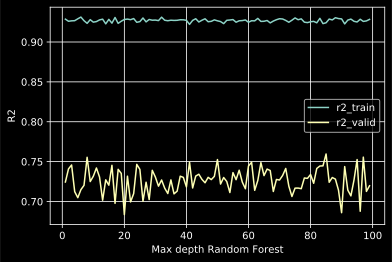

In [8]:
r2_train_plot = []
r2_valid_plot = []
i_plot = []

for i in range(1, 100):
    x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.25, random_state=i)
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_valid = scaler.transform(x_valid)
    x_test = scaler.transform(df_test)
    
    model = RandomForestRegressor(random_state=42, max_depth=14)
    model.fit(x_train, y_train)

    y_test = model.predict(x_test)
    y_pred = model.predict(x_valid)
    mae_valid = mae(y_valid, y_pred)
    #print(f'MAE valid: {mae_valid.round(0)}')

    y_pred_train = model.predict(x_train)
    mse_valid = mse(y_valid, y_pred)
    #print(f'MSE valid: {mse_valid.round(0)}')

    r2_train = r2(y_train, y_pred_train)
    print(f'R2 train: {r2_train.round(4)}')
    r2_valid = r2(y_valid, y_pred)
    print(f'R2 valid: {r2_valid.round(4)}')
    print('i = ', i)
    model
    
    r2_train_plot.append(r2_train)
    r2_valid_plot.append(r2_valid)
    i_plot.append(i)

plt.plot(i_plot, r2_train_plot, label='r2_train')
plt.plot(i_plot, r2_valid_plot, label='r2_valid')
plt.xlabel('Max depth Random Forest')
plt.ylabel('R2')
plt.legend()
plt.grid()
plt.show()

## Random Forest Regressor

обучение на всей выборке без разделения на тренировочную и валидационную

In [17]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x)

x_test = scaler.transform(df_test)

model = RandomForestRegressor(random_state=42, max_depth=14)
model.fit(x_train, y)

y_test = model.predict(x_test)

y_pred_train = model.predict(x_train)

r2_train = r2(y, y_pred_train)
print(f'R2 train: {r2_train.round(4)}')
model

R2 train: 0.9198


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=14, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [31]:
model.feature_importances_
feature_importances = pd.DataFrame()
feature_importances['importance'] = model.feature_importances_
feature_importances['feature_name'] = x.columns.tolist()
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
feature_importances

,importance,feature_name
2,0.415365,Square
8,0.106726,Social_1
9,0.095741,Social_2
1,0.081738,Rooms
10,0.058641,Social_3
0,0.047225,DistrictId
7,0.042963,Ecology_1
6,0.036619,HouseYear
3,0.026464,KitchenSquare
11,0.024246,Healthcare_1


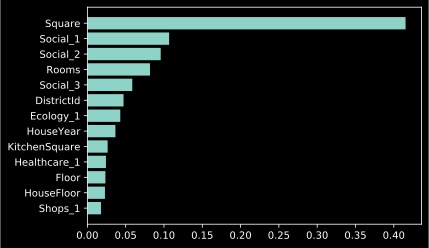

In [30]:
feature_importances = feature_importances.sort_values(by='importance', ascending=True)
height = feature_importances['importance']
bars = feature_importances['feature_name']
y_pos = np.arange(len(bars))
# Create horizontal bars
plt.barh(y_pos, height)
 # Create names on the y-axis
plt.yticks(y_pos, bars)
plt.show()

# Экспорт в CSV

In [18]:
#check_test = pd.DataFrame({'y_test_1': y_valid.round(), 'y_pred': y_pred.round()})
#check_test.head(10)
df_y_test = pd.DataFrame({'Id': df_test_orig['Id'], 'Price': y_test})
df_y_test.to_csv('../../data/house_price/AKalinichenko_predictions.csv', index=False, encoding='utf-8')
print('Done!')

Done!


# Построение графиков предсказанных значений

R2:	0.713
MAE:	29540.0
MSE:	2524272516.0


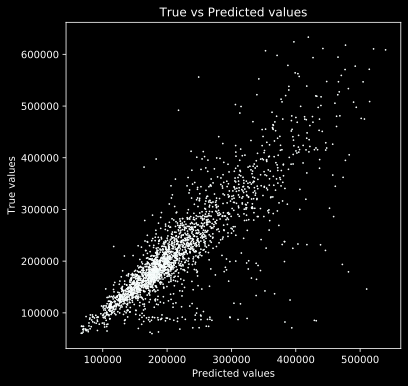

R2:	0.929
MAE:	16151.0
MSE:	607234284.0


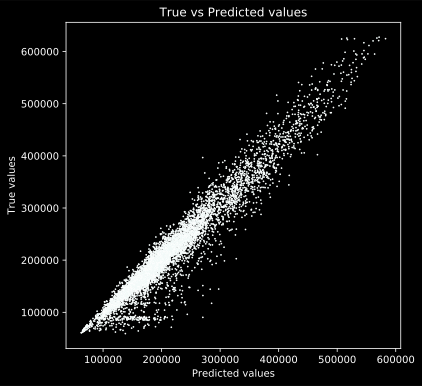

In [130]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 0)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 0))) 
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=pred_values, y=true_values, s=1)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

evaluate_preds(y_valid.values.flatten(), y_pred.flatten())
evaluate_preds(y_train.values.flatten(), y_pred_train.flatten())